<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [2]:
data = pd.read_csv('winequality-red.csv', sep=';')

In [3]:
data['quality'] = data['quality'].apply(lambda x: 1 if x > 5 else 0)

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('quality', axis=1), data['quality'], test_size=0.2)

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [7]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

In [12]:
np.array([cross_val_score(DecisionTreeClassifier(max_depth=d), X_train, y_train, cv=5, scoring='roc_auc').mean()
         for d in range(2, 10)]).argmax() + 2

6

In [13]:
cross_val_score(DecisionTreeClassifier(max_depth=6), X_train, y_train, cv=5, scoring='roc_auc').mean()

0.77513453428238832

In [10]:
train_scores, test_scores = validation_curve(DecisionTreeClassifier(), X_train, y_train,
                                             param_name="max_depth", param_range=range(3, 10),
                                             cv=5, scoring='roc_auc')

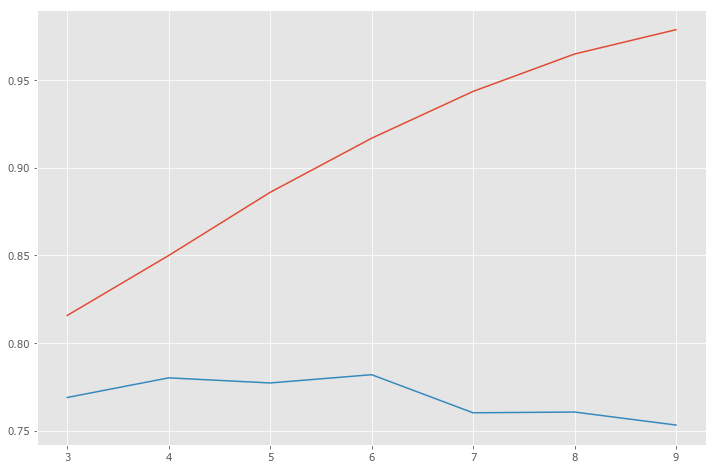

In [11]:
plt.plot(range(3, 10), train_scores.mean(axis=1))
plt.plot(range(3, 10), test_scores.mean(axis=1))

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [38]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [39]:
sorted(clf.feature_importances_, reverse=True)

[0.41458890757365863,
 0.19758816287743083,
 0.092484697516761208,
 0.069036012917745956,
 0.064233362622545725,
 0.048320968834195045,
 0.041284683000071237,
 0.031891914994385588,
 0.021658799996929004,
 0.018912489666276608,
 0.0]

<Container object of 11 artists>

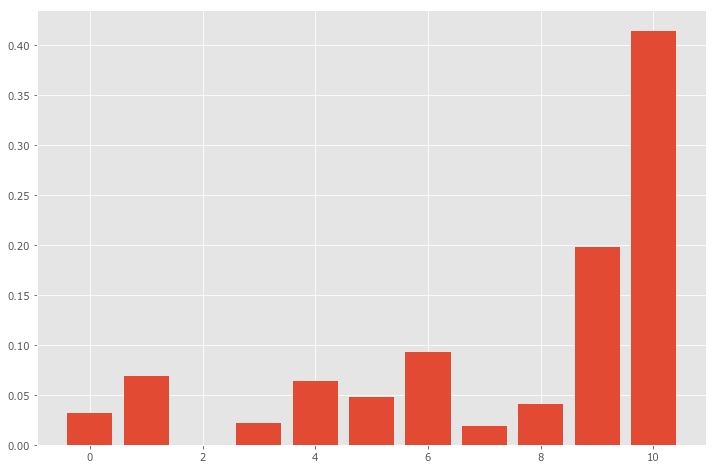

In [40]:
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)

#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [42]:
y_test_predicted_proba = clf.predict_proba(X_test)

In [43]:
y_train_predicted_proba = clf.predict_proba(X_train)

In [44]:
fpr, tpr, thres_test  = roc_curve(y_test, y_test_predicted_proba[:,1])
fpr_train, tpr_train, thres_train = roc_curve(y_train, y_train_predicted_proba[:,1])

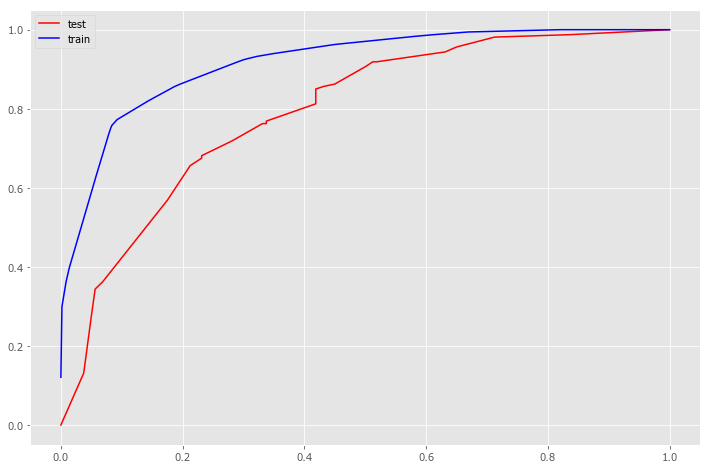

In [45]:
line1 = plt.plot(fpr, tpr, color='red', label='test')
line2 = plt.plot(fpr_train, tpr_train, color='blue', label='train')
plt.legend()

In [46]:
# можно сделать clf.predict(...) и получим тоже самое
y_test_predicted = map(lambda x: 1 if x > 0.5 else 0, y_test_predicted_proba[:,1])

In [47]:
precision_score(y_test, map(lambda x: 1 if x > 0.5 else 0, y_test_predicted))

0.71875

In [48]:
recall_score(y_test, map(lambda x: 1 if x > 0.5 else 0, y_test_predicted_proba[:,1]))

0.71875

In [49]:
accuracy_score(y_test, map(lambda x: 1 if x > 0.5 else 0, y_test_predicted_proba[:,1]))

0.71875

#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [50]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [51]:
bagging_scores = [cross_val_score(BaggingClassifier(n_estimators=10 * i, 
                    base_estimator=DecisionTreeClassifier(max_depth=6)), 
                     X_train, y_train, cv=5, scoring='roc_auc').mean() for i in range(1, 10)]

In [53]:
forest_scores = [cross_val_score(RandomForestClassifier(n_estimators=10 * i, max_depth=6), 
                     X_train, y_train, cv=5, scoring='roc_auc').mean() for i in range(1, 10)]

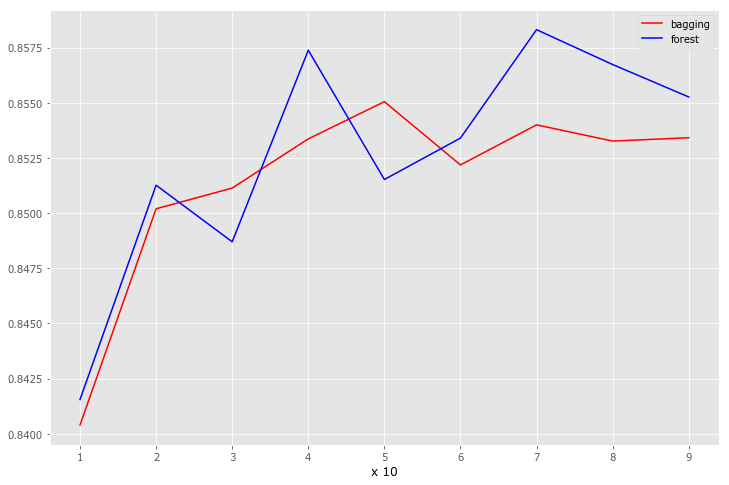

In [54]:
bagging_plot = plt.plot(range(1, 10), bagging_scores, color='red', label='bagging')
forest_plot = plt.plot(range(1, 10), forest_scores, color='blue', label='forest')
plt.xlabel('x 10', color='black')
plt.legend()

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
forest_cv = GridSearchCV(RandomForestClassifier(), 
                         param_grid={'n_estimators' : range(20, 51), 'max_depth':range(3, 6)}, 
                         scoring='roc_auc', n_jobs=2)

In [57]:
forest_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [58]:
forest_cv.best_params_

{'max_depth': 5, 'n_estimators': 36}

In [61]:
cross_val_score(RandomForestClassifier(max_depth=5, n_estimators=36), 
                X_train, y_train, cv=5, scoring='roc_auc').mean()

0.8437727271763491

In [63]:
forest = RandomForestClassifier(max_depth=5, n_estimators=36)

In [64]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=36, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [65]:
y_test_forest_predicted_proba = forest.predict_proba(X_test)

In [66]:
roc_auc_score(y_test, y_test_forest_predicted_proba[:,1])

0.82285156250000013